Load a time series of MODIS (MxD021KM) Radiance observations from a directory

In [1]:
import xarray as xr
import gdal
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
from scipy import interpolate
import cartopy.crs as ccrs
import datetime as dt

%matplotlib inline

Find all HDF files in a specified directory

In [2]:
def getListOfFiles(dirName,ext):
    '''Create a list of file names in the given directory with specified file extension.'''
    # https://thispointer.com/python-how-to-get-list-of-files-in-directory-and-sub-directories/
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Only match files with the correct extension
        if '.'+ext == os.path.splitext(entry)[1]:
            # Create full path and add to list
            fullPath = os.path.join(dirName, entry)
            allFiles.append(fullPath)       
    return allFiles

In [3]:
rad_searchDir = r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\MODIS\Tuolumne_2017_MxD021KM'
rad_file_list = getListOfFiles(rad_searchDir,'hdf')

geo_searchDir = r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\MODIS\Tuolumne_2017_MxD03'
geo_file_list = getListOfFiles(geo_searchDir,'hdf')

Open the 1 KM resolution "Emissive" (LWIR) bands from all the datasets

In [4]:
lwir_rad = [gdal.Open('HDF4_EOS:EOS_SWATH:"{}":MODIS_SWATH_Type_L1B:EV_1KM_Emissive'.format(path)) for path in rad_file_list]
geo_lat = [gdal.Open('HDF4_SDS:UNKNOWN:"{}":0'.format(path)) for path in geo_file_list]
geo_lon = [gdal.Open('HDF4_SDS:UNKNOWN:"{}":1'.format(path)) for path in geo_file_list]

In [5]:
offsets = np.array([2730.583496, 2730.583496, 2730.583496, 2730.583496, 1077.444824, 1560.333374, 2730.583252, 2317.488281, 2730.583496, 1560.333252, 1577.339722, 1658.221313, 2501.297607, 2501.297607, 2501.297852, 2501.297852])
scales = np.array([6.262398529e-05, 0.003149510128, 6.921597378e-05, 7.910397835e-05, 3.155614104e-05, 5.639820665e-05, 0.0001175572979, 0.0001924497337, 0.0005324869417, 0.0004063234373, 0.0008400219958, 0.0007296975818, 0.0002622638713, 0.0002006958239, 0.0001767082722, 0.0001183385684])

In [6]:
n_files = 18
n_bands = 16
# Because the MODIS products are either 2030 or 2040 pixels in 5 minutes...
# I'm truncating them all to just 2030
along_track_px = 2030
cross_track_px = 1354

# Create empty arrays to hold the radiance, lat, and lon

rad = np.ones((n_files,   # Number of MODIS HDF files
               n_bands,         # Number of bands
               along_track_px,  # Width
               cross_track_px), # Height
              dtype='float64')

lon = np.ones((n_files,   # Number of MODIS HDF files
               along_track_px,  # Width
               cross_track_px), # Height
              dtype='float64')

lat = np.ones((n_files,   # Number of MODIS HDF files
               along_track_px,  # Width
               cross_track_px), # Height
              dtype='float64')

***
***

In [138]:
# For each file in the timeseries of MODIS observations
k = 0
for i in range(0,n_files):
    # Read the date and time from the MxD021KM Radiance product
    date = lwir_rad[i].GetMetadataItem('RANGEBEGINNINGDATE')
    time = lwir_rad[i].GetMetadataItem('RANGEBEGINNINGTIME')
    # Find its matching MxD03 Geolocation product
    for j in range(0,n_files):
        date2 = geo_lat[j].GetMetadataItem('RANGEBEGINNINGDATE')
        time2 = geo_lat[j].GetMetadataItem('RANGEBEGINNINGTIME')
        # Once we find a match, load these into our arrays
        if date==date2 and time==time2:
            print('Found files for {} {}'.format(date,time))
            # Load the radiance scaled integer values
            scaled_integer_rad = lwir_rad[i].ReadAsArray()
            # For each band, scale the radiance values into W/m2
            for band in range(0,scales.shape[0]):
                rad[k,band] = scales[band] * (scaled_integer_rad[band,0:along_track_px,0:cross_track_px] - offsets[band])
            # Read the latitudes and longitudes from the geolocaiton product
            lat[k] = geo_lat[j].ReadAsArray()[0:along_track_px,0:cross_track_px]
            lon[k] = geo_lon[j].ReadAsArray()[0:along_track_px,0:cross_track_px]
            k+=1

print('{} out of {} files loaded with geolocation information'.format(k,n_files))

Found files for 2017-04-19 05:20:00.000000
Found files for 2017-04-19 19:00:00.000000
Found files for 2017-04-20 06:05:00.000000
Found files for 2017-04-20 18:05:00.000000
Found files for 2017-04-20 19:45:00.000000
Found files for 2017-04-21 05:10:00.000000
Found files for 2017-04-21 06:50:00.000000
Found files for 2017-04-21 18:50:00.000000
Found files for 2017-04-22 05:50:00.000000
Found files for 2017-04-22 19:30:00.000000
Found files for 2017-04-19 09:35:00.000000
Found files for 2017-04-19 20:40:00.000000
Found files for 2017-04-20 10:20:00.000000
Found files for 2017-04-20 21:25:00.000000
Found files for 2017-04-21 09:25:00.000000
Found files for 2017-04-21 20:30:00.000000
16 out of 18 files loaded


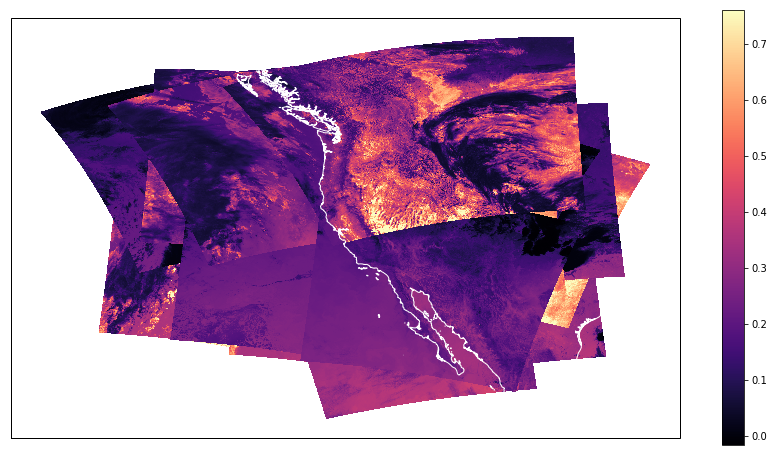

In [151]:
# Just do some quick plotting to make sure I'm looking at the right timestamps ...
# ...in the metadata and everyting lines up as I'd hope
band=0

plt.figure(figsize=(15,8))
#img_extent = (-124, -115, 33, 40)
ax = plt.axes(projection=ccrs.PlateCarree()) #extent=img_extent,
ax.coastlines(resolution='10m', color='white', linewidth=1)
for i in range(0,18): # Plot each observation
    max_color_rad = np.mean(rad[:,band]) + 2*np.std(rad[:,band]) # mean + 2stddev
    min_color_rad = np.min(rad[:,band]) # min
    plt.pcolormesh(lon[i], lat[i], rad[i,band], 
                   vmin=min_color_rad, vmax=max_color_rad, 
                   cmap='magma', transform=ccrs.PlateCarree())
plt.colorbar()
plt.show()

***
***
Trying to combine data into a single xarray dataset

In [173]:
arr = xr.DataArray(rad[0],dims=('band', 'line', 'pixel'))

In [203]:
date, time

('2017-04-21', Timestamp('2017-04-21 00:00:00'))

In [233]:
radiance = rad[0]
latitude = lat[0]
longitude = lon[0]
time = pd.Timestamp(date)

ds1 = xr.Dataset({'radiance': (['band', 'line', 'pixel'],  radiance)},
                coords={'longitude': (['line', 'pixel'], longitude),
                        'latitude': (['line', 'pixel'], latitude),
                        'time': time})


radiance = rad[1]
latitude = lat[1]
longitude = lon[1]

ds2 = xr.Dataset({'radiance': (['band', 'line', 'pixel'],  radiance)},
                coords={'longitude': (['line', 'pixel'], longitude),
                        'latitude': (['line', 'pixel'], latitude),
                        'time': time})

In [240]:
ds = xr.concat([ds1,ds2],'time')

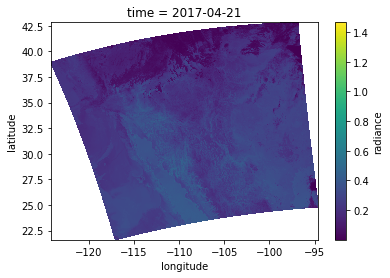

In [266]:
ds.radiance[0,0].plot(x='longitude',y='latitude')

***
***

In [7]:
# For each file in the timeseries of MODIS observations
k = 0
for i in range(0,n_files):
    # Read the date and time from the MxD021KM Radiance product
    date = lwir_rad[i].GetMetadataItem('RANGEBEGINNINGDATE')
    time = lwir_rad[i].GetMetadataItem('RANGEBEGINNINGTIME')
    # Find its matching MxD03 Geolocation product
    for j in range(0,n_files):
        date2 = geo_lat[j].GetMetadataItem('RANGEBEGINNINGDATE')
        time2 = geo_lat[j].GetMetadataItem('RANGEBEGINNINGTIME')
        # Once we find a match, load these into our arrays
        if date==date2 and time==time2:
            print('Found files for {} {}'.format(date,time))
            # Load the radiance scaled integer values
            scaled_integer_rad = lwir_rad[i].ReadAsArray()
            # For each band, scale the radiance values into W/m2
            for band in range(0,scales.shape[0]):
                rad[k,band] = scales[band] * (scaled_integer_rad[band,0:along_track_px,0:cross_track_px] - offsets[band])
            # Read the latitudes and longitudes from the geolocaiton product
            lat[k] = geo_lat[j].ReadAsArray()[0:along_track_px,0:cross_track_px]
            lon[k] = geo_lon[j].ReadAsArray()[0:along_track_px,0:cross_track_px]
            # Add the MODIS data to an xarray dataset
            if k==0: # If this is our first file, make a new dataset
                ds = xr.Dataset({'radiance': (['band', 'line', 'pixel'],  rad[k])},
                                coords={'longitude': (['line', 'pixel'], lon[k]),
                                        'latitude': (['line', 'pixel'], lat[k]),
                                        'time': pd.to_datetime('{} {}'.format(date,time))})
            else: # append to existing dataset
                ds_new = xr.Dataset({'radiance': (['band', 'line', 'pixel'],  rad[k])},
                                coords={'longitude': (['line', 'pixel'], lon[k]),
                                        'latitude': (['line', 'pixel'], lat[k]),
                                        'time': pd.to_datetime('{} {}'.format(date,time))})
                ds = xr.concat([ds,ds_new],'time')
            k+=1 # add to the successful file load counter
            
print('{} out of {} files loaded with geolocation information'.format(k,n_files))

Found files for 2017-04-19 05:20:00.000000
Found files for 2017-04-19 19:00:00.000000
Found files for 2017-04-20 06:05:00.000000
Found files for 2017-04-20 18:05:00.000000
Found files for 2017-04-20 19:45:00.000000
Found files for 2017-04-21 05:10:00.000000
Found files for 2017-04-21 06:50:00.000000
Found files for 2017-04-21 18:50:00.000000
Found files for 2017-04-22 05:50:00.000000
Found files for 2017-04-22 19:30:00.000000
Found files for 2017-04-19 09:35:00.000000
Found files for 2017-04-19 20:40:00.000000
Found files for 2017-04-20 10:20:00.000000
Found files for 2017-04-20 21:25:00.000000
Found files for 2017-04-21 09:25:00.000000
Found files for 2017-04-21 20:30:00.000000
16 out of 18 files loaded with geolocation information


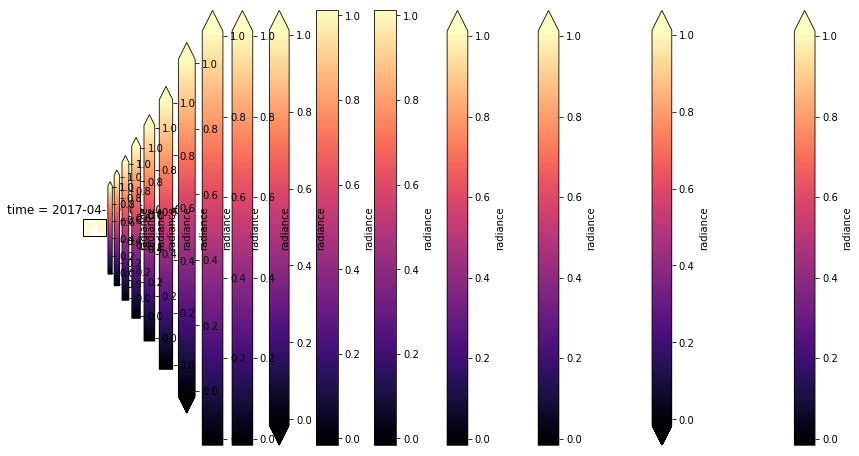

In [8]:
# Just do some quick plotting to make sure I'm looking at the right timestamps ...
# ...in the metadata and everyting lines up as I'd hope
band=0

plt.figure(figsize=(15,8))
#img_extent = (-124, -115, 33, 40)
ax = plt.axes(projection=ccrs.PlateCarree()) #extent=img_extent,
ax.coastlines(resolution='10m', color='white', linewidth=1)
for t in range(0,ds.time.shape[0]):
    max_color_rad = np.mean(rad[:,band]) + 2*np.std(rad[:,band]) # mean + 2stddev
    min_color_rad = np.min(rad[:,band]) # min
    ds.radiance[band,t].plot(x='longitude',y='latitude', 
               ax=ax,vmin=min_color_rad, vmax=max_color_rad, 
               cmap='magma', transform=ccrs.PlateCarree())

#plt.colorbar()
plt.show()

***
***

Find the radiance value for a pixel at a specific location specified by a latitude and longitude

And make some plots around our area of interest

In [94]:
lat_obs = 37.88 #approx locaiton of Gaylor Pit
long_obs=-119.31
radiance=[]
datetime=[]
viewtime=[]
viewangle=[]
temp_mean=[]
temp_min=[]
temp_max=[]
b=0.5 #bounds, +/- in degrees lat/lon
n=0
for f in datasets_new:
    # Find LST value at the specified coordinates
    coordinates = np.unravel_index((np.abs(f.Latitude_1km - lat_obs) + np.abs(f.Longitude_1km - long_obs)).argmin(), f.Latitude_1km.shape)
    temp.append(f.LST[coordinates].values - 273.15)
    # Make a separate array of pixels around our point of interest
    m = 1 # for a 3x3 grid, m=1
    temp_grid = f.LST[coordinates[0]-m:coordinates[0]+1+m,coordinates[1]-m:coordinates[1]+1+m].values
    temp_mean.append(np.nanmean(temp_grid) - 273.15)
    temp_min.append(np.nanmin(temp_grid) - 273.15)
    temp_max.append(np.nanmax(temp_grid) - 273.15)
    
    # Find the date and time of this observation
    i = f.attrs['CoreMetadata.0'].find('RANGEBEGINNINGDATE')
    date = f.attrs['CoreMetadata.0'][i+80:i+90]
    i = f.attrs['CoreMetadata.0'].find('RANGEBEGINNINGTIME')
    time = f.attrs['CoreMetadata.0'][i+80:i+95]
    datetime.append(pd.to_datetime('{} {}'.format(date,time)))
    
    # Record view time and view angle of this point
    viewtime.append(f.View_time[coordinates].values)
    viewangle.append(f.View_angle[coordinates].values)
    
    # print and save figure
    #fig, ax = plt.subplots(figsize=(7,7))
    #ax = plt.axes(projection=ccrs.Orthographic(-117, 39))
    #f.LST.plot.pcolormesh('Longitude_1km', 'Latitude_1km',cmap='magma',
    #                      vmin=250, vmax=350, ax=ax, transform=ccrs.PlateCarree(),zorder=30);
    ##ax.set_global(); #ax.stock_img();
    #ax.coastlines();
    #ax.gridlines();
    #ax.set_extent([long_obs-b,long_obs+b, lat_obs-b,lat_obs+b], crs=ccrs.PlateCarree())
    #ax.set_title('MODIS LST {}'.format(datetime[n]))
    #plt.savefig('figures/MODIS LST {}.png'.format(n))
    #plt.close('all')
    n+=1

d = {'datetime': datetime, 
     'temperature': temp, 
     'viewtime': viewtime, 
     'viewangle': viewangle,
     'temp_min': temp_min,
     'temp_max': temp_max,
     'temp_mean': temp_mean
     }
modis = pd.DataFrame(data=d)
modis['datetime'] +=  pd.to_timedelta(-7, unit='h')
modis = modis.sort_values('datetime').reset_index()

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: All-NaN slice encountered
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: All-NaN slice encountered
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: All-NaN slice encountered
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: All-NaN slice encountered


In [95]:
modis

,index,datetime,temperature,viewtime,viewangle,temp_min,temp_max,temp_mean
0,0,2017-04-19 23:05:00,-5.489996,22.2,10.0,-6.329993,-4.530005,-5.590002
1,8,2017-04-20 03:20:00,-6.290015,2.4,38.5,-6.510016,-5.470007,-6.097998
2,1,2017-04-20 11:05:00,4.369989,10.2,60.5,1.929987,4.369989,2.990015
3,2,2017-04-20 12:45:00,1.990015,11.8,64.5,-0.570013,3.529993,1.558862
4,9,2017-04-20 14:25:00,NaN,nan,nan,3.369989,4.529993,3.969995
5,3,2017-04-20 22:10:00,-4.410010,21.2,62.5,-7.230017,-4.410010,-5.700018
6,4,2017-04-20 23:50:00,-4.590002,22.9,62.5,-5.870001,-4.470007,-5.130011
7,10,2017-04-21 02:25:00,-4.190009,1.5,49.5,-5.570013,-4.190009,-4.616675
8,5,2017-04-21 11:50:00,7.230005,10.9,4.0,5.829980,7.230005,6.449976
9,11,2017-04-21 13:30:00,NaN,nan,nan,4.290002,6.890009,5.663324


Load Gaylor Pit snow surface temperature data

In [96]:
# Gaylor Pit surface temperature data
filepath = r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\MountainGOES\GaylorPit\GaylorPit2017_039_T15min.csv'
gaylor = pd.read_csv(filepath)

# Make some data type and unit conversions
gaylor['datetime'] = pd.to_datetime(gaylor['TIMESTAMP']) # timestamp string to pandas datetime
gaylor['Judd_Air_TempC'] = (gaylor['Judd_Air_TempF'] - 32) / 1.8 # temperature F to temperature C
gaylor['Judd_Depth_cm'] = gaylor['Judd_Depth_in'] * 2.54 # snowdepth inches to snowdepth cm


Plot MODIS LST and Gaylor Pit temperature data together

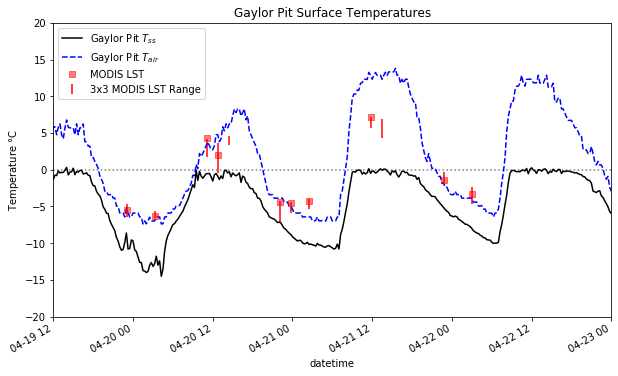

In [97]:
starttime = pd.to_datetime('2017-04-19 12:00')
endtime = pd.to_datetime('2017-04-23')

fig, ax = plt.subplots(figsize=(10,6))

plt.plot([starttime, endtime],[0, 0],':',c='tab:grey')

gaylor.plot(x='datetime',y='TT_C', color='k', ax=ax, label= 'Gaylor Pit $T_{ss}$')
gaylor.plot(x='datetime',y='Judd_Air_TempC', linestyle='--', color='b', ax=ax, label= 'Gaylor Pit $T_{air}$')
modis.plot(x='datetime',y='temperature',
           marker='s',c='r',linestyle='None',ax=ax,
           label='MODIS LST',alpha=0.5)
plt.errorbar(modis.datetime,modis.temp_mean,
             yerr=np.array((modis.temp_max-modis.temp_min)/2),
             linestyle='None',c='r',linewidth=1.5,
             label='{}x{} MODIS LST Range'.format((m*2)+1,(m*2)+1))

plt.legend()
ax.set_xlim((starttime,endtime))
ax.set_ylim((-20,20))
ax.set_ylabel('Temperature $\degree$C');
ax.set_title('Gaylor Pit Surface Temperatures');

Find the Gaylor Pit observations closest in time to our MODIS data, compute the difference between MODIS LST and Gaylor Pit Tsnow and Tair

In [98]:
def nearest(items, pivot):
    #https://stackoverflow.com/questions/32237862/find-the-closest-date-to-a-given-date
    return min(items, key=lambda x: abs(x - pivot))

In [112]:
# Compute the difference in temperatures (Gaylor Pit - MODIS)
delta_tair = []
delta_tsnow = []
gaylor_tair = []
gaylor_tsnow = []

i = 0
for time in modis['datetime']:
    gaylor_time = (nearest(gaylor['datetime'],time))
    #print('MODIS Time:{} \t Gaylor Time:{}'.format(time,gaylor_time))
    gaylor_tsnow.append(gaylor['TT_C'][gaylor['datetime']==gaylor_time].values[0])
    gaylor_tair.append(gaylor['Judd_Air_TempC'][gaylor['datetime']==gaylor_time].values[0])
    modis_t = modis.temperature[modis['datetime']==time].values[0]
    modis_tmin = modis.temp_min[modis['datetime']==time].values[0]
    modis_tmax = modis.temp_max[modis['datetime']==time].values[0]
    #print('{} \t {} \t {}'.format(modis_t,gaylor_tsnow,gaylor_tair))
    delta_tsnow.append(modis_t - gaylor_tsnow[i])
    delta_tair.append(modis_t - gaylor_tair[i])
    i+=1


How does the difference between MODIS LST and ground data change as a function of view angle?

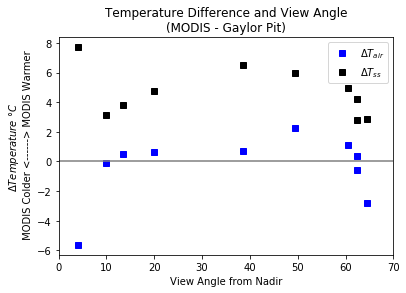

In [114]:
plt.plot(modis.viewangle,delta_tair,'sb',label='$\Delta T_{air}$',alpha=1);
plt.plot(modis['viewangle'],delta_tsnow,'sk',label='$\Delta T_{ss}$',alpha=1);

plt.xlabel('View Angle from Nadir')
plt.ylabel('$\Delta Temperature \,\, \degree C$\n MODIS Colder <------> MODIS Warmer')
plt.legend()
plt.xlim([0,70])
plt.plot([0, 70],[0, 0],'-',c='tab:grey')
plt.title('Temperature Difference and View Angle\n(MODIS - Gaylor Pit)');

# These MODIS LST values are often warmer than both Gaylor Pit Tair and Ts

If we assume a weighted mean between tforest (guessing that it can be represented here by tair) and tsnow, figure out what those weights are here.

In other words:

MODIS LST = ( (1-n) * Tforest + n * Tsnow )

where 1-n is the forest fraction of the pixel, and n is the snow fraction of the pixel

Therefore solving for n:

n = (MODIS LST - Tforest) / (Tsnow - Tforest)

In [115]:
snow_fraction = []
for i in range(0,len(modis.temperature)):
    snow_fraction.append(( modis.temperature[i] - gaylor_tair[i] ) / (gaylor_tsnow[i] - gaylor_tair[i]))


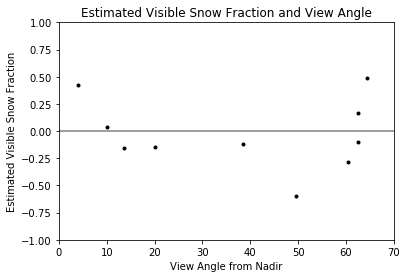

In [116]:
plt.plot(modis['viewangle'],snow_fraction,'.k');
plt.xlabel('View Angle from Nadir')
plt.ylabel('Estimated Visible Snow Fraction')
plt.xlim([0,70])
plt.ylim([-1,1])
plt.plot([0, 70],[0, 0],'-',c='tab:grey')
plt.title('Estimated Visible Snow Fraction and View Angle');

# Where snow fraction is < 0, MODIS LST is higher than Tair